In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pmdarima import auto_arima

## Model 0 - ARIMA

In [3]:
# https://github.com/das-amlan/Stock-Price-Forecasting/blob/main/Stock_price_forecasting.ipynb

In [4]:
df_nasdaq = pd.read_csv('df_nasdaq.csv')
df_sp500 = pd.read_csv('df_sp500.csv')
df_dji = pd.read_csv('df_dji.csv')

In [5]:
df_close = pd.DataFrame({
    'Date': df_nasdaq['Date'],
    'nasdaq': df_nasdaq['Close'],
    'sp500': df_sp500['Close'],
    'dji': df_dji['Close']
})

df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index('Date', inplace=True)

train_size = int(len(df_close) * 0.8)
df_train_close = df_close[:train_size]
df_test_close = df_close[train_size:]

print(df_close.head())
print(f"Shape of training set: {df_train_close.shape}")
print(f"Shape of testing set: {df_test_close.shape}")

                 nasdaq        sp500           dji
Date                                              
2019-03-14  7630.910156  2808.479980  25709.939453
2019-03-15  7688.529785  2822.479980  25848.869141
2019-03-18  7714.479980  2832.939941  25914.099609
2019-03-19  7723.950195  2832.570068  25887.380859
2019-03-20  7728.970215  2824.229980  25745.669922
Shape of training set: (1097, 3)
Shape of testing set: (275, 3)


### Seasonal Decomposition

<Figure size 432x288 with 0 Axes>

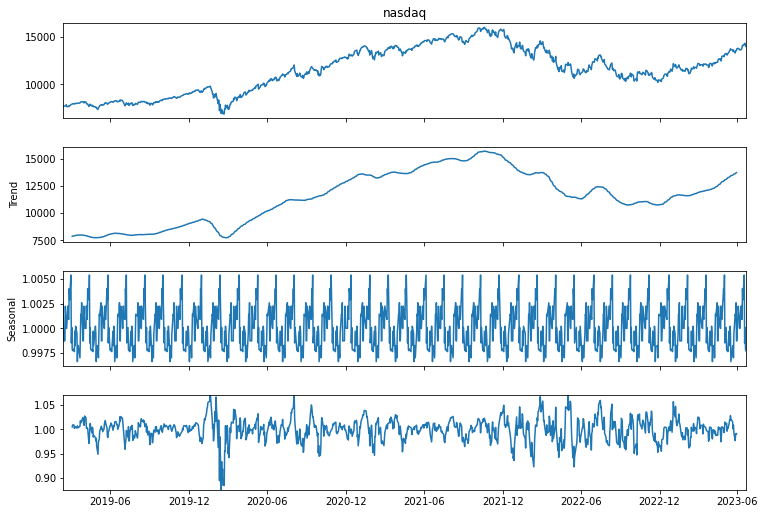

<Figure size 432x288 with 0 Axes>

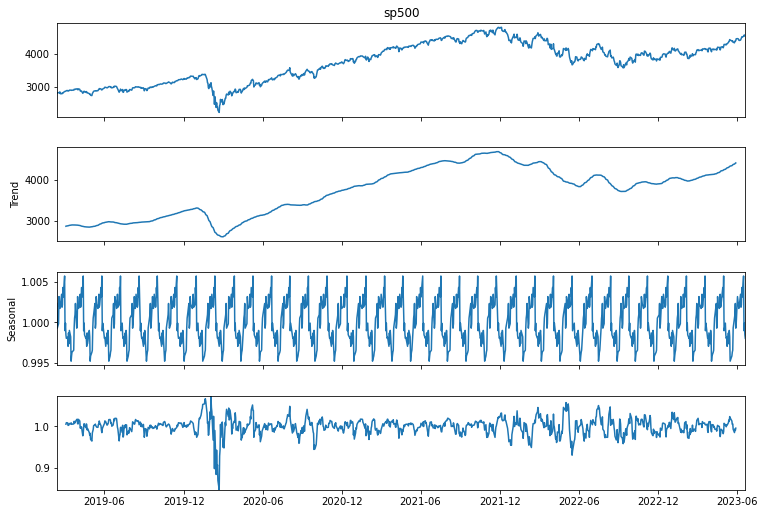

<Figure size 432x288 with 0 Axes>

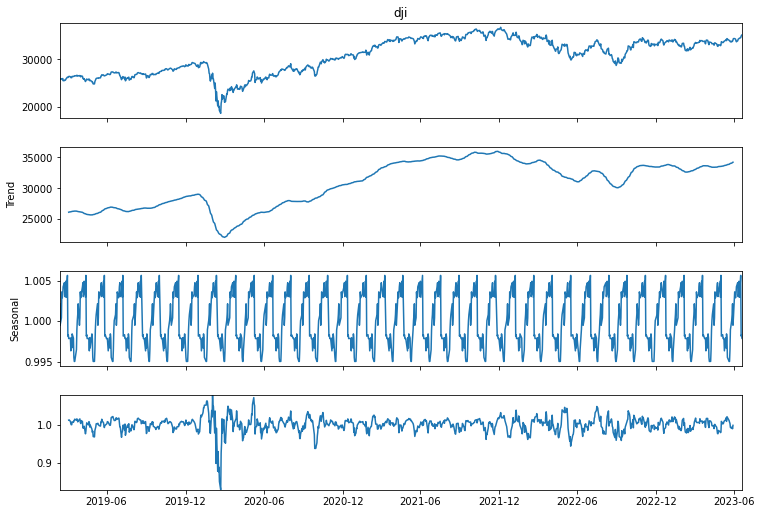

In [6]:
stock_name = ['nasdaq', 'sp500', 'dji']
for i in stock_name:
    result = seasonal_decompose(df_train_close[i], model='multiplicative', period=30)
    fig = plt.figure()  
    fig = result.plot()  
    plt.title(i) 
    fig.set_size_inches(12, 8)
    
    # Change the y-axis of residual plot
    residual_ax = fig.axes[3]
    residual_ax.clear()
    residual_ax.plot(result.resid.index, result.resid)
    residual_ax.set_ylim(result.resid.min(), result.resid.max())
    
plt.show()

### ADF test - Check Stationary

In [7]:
for i in stock_name:
    print([i])
    result = adfuller(df_train_close[i], autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject Null Hypothesis. So, Time Series is Stationary")
    else:
        print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
    print("\n")

['nasdaq']
ADF Statistic: -1.488997
p-value: 0.538947
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['sp500']
ADF Statistic: -1.403012
p-value: 0.580831
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['dji']
ADF Statistic: -1.729701
p-value: 0.415878
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




### Normality Test

In [8]:
for i in stock_name:
    print([i])
    stat, p = normaltest(df_train_close[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['nasdaq']
Statistics=450.441, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['sp500']
Statistics=716.444, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['dji']
Statistics=145.980, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)




### log Transformation

In [9]:
df_train_close_log = np.log(df_train_close / df_train_close.shift(1))
df_train_close_log = df_train_close_log.dropna()
print(df_train_close_log.head())

              nasdaq     sp500       dji
Date                                    
2019-03-15  0.007522  0.004973  0.005389
2019-03-18  0.003369  0.003699  0.002520
2019-03-19  0.001227 -0.000131 -0.001032
2019-03-20  0.000650 -0.002949 -0.005489
2019-03-21  0.014131  0.010794  0.008387


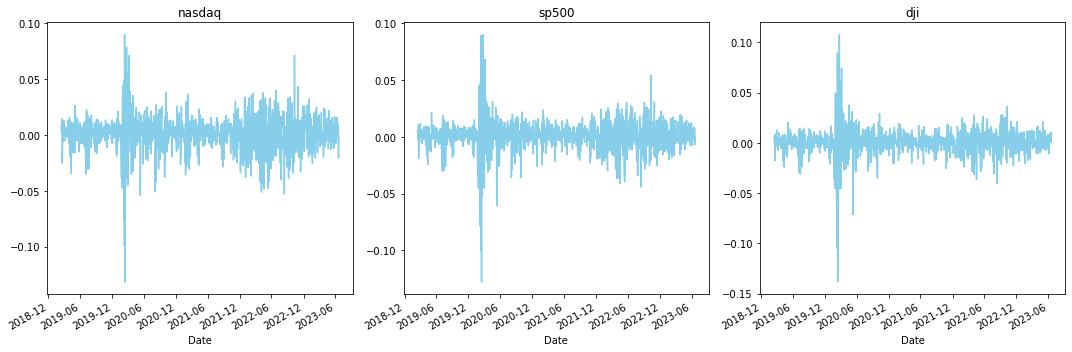

In [10]:
num_columns = len(df_train_close_log.columns)
fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 5, 5))

for i, column in enumerate(df_train_close_log.columns):
    df_train_close_log[column].plot(ax=axes[i], color='skyblue')
    axes[i].set_title(column)

plt.tight_layout()
plt.savefig('graph/log_transformed_data_plot.jpg')
plt.show()

### ADF test and Normality test for log-transformed data

In [11]:
for i in stock_name:
    print([i])
    result = adfuller(df_train_close_log[i], autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject Null Hypothesis. So, Time Series is Stationary")
    else:
        print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
    print("\n")

['nasdaq']
ADF Statistic: -10.065512
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary


['sp500']
ADF Statistic: -9.761586
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary


['dji']
ADF Statistic: -9.878980
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary




In [11]:
for i in stock_name:
    print([i])
    stat, p = normaltest(df_train_close_log[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['nasdaq']
Statistics=227.458, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['sp500']
Statistics=334.136, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['dji']
Statistics=410.564, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)




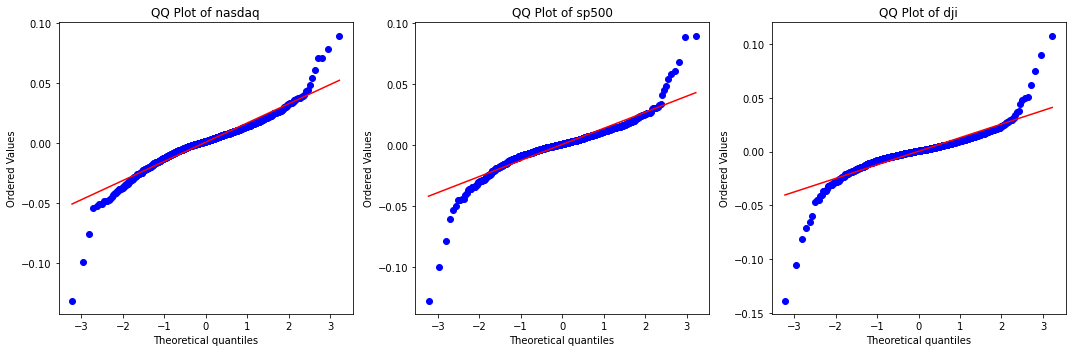

In [12]:
num_columns = len(df_train_close_log.columns)
fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 5, 5))

for i, column in enumerate(df_train_close_log.columns):
    stats.probplot(df_train_close_log[column].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ Plot of {column}')

plt.tight_layout()
plt.show()

In [13]:
# Dateset are not normally distributed.
# Maybe can use Generalized Additive Models (GAM) to fit.

### Fit ARIMA model

In [14]:
arima_models = {}

for stock in stock_name:
    print(f"Fitting ARIMA model for {stock}...")
    model = auto_arima(df_train_close_log[stock], seasonal=False, trace=True, stepwise=True)
    arima_models[stock] = model
    print(f"Best ARIMA model for {stock}: {model.summary()}\n")

Fitting ARIMA model for nasdaq...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5903.001, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5875.837, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5904.386, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5900.321, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5907.346, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-5905.391, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5905.319, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5905.518, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5903.436, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5906.851, Time=0.11 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 1.731 seconds
Best ARIMA model for nasdaq:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:           

### ARIMA - Single-step Prediction

In [19]:
forecasted_close = pd.DataFrame(index=df_test_close.index, columns=stock_name)
history_dict = {stock: list(df_train_close_log[stock]) for stock in stock_name}

for stock in stock_name:
    model = arima_models[stock]
    forecasted_close[stock] = np.nan
    
    for i in range(len(df_test_close)):
        next_pred_log = model.predict(n_periods=1)
        forecasted_close.at[df_test_close.index[i], stock] = next_pred_log.values[0]
        history_dict[stock].append(next_pred_log.values[0])

    last_known_price = df_train_close[stock].iloc[-1]
    forecasted_close[stock] = np.exp(forecasted_close[stock].cumsum()) * last_known_price

/root/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/root/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/root/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/root/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_

In [22]:
print("The single-step prediction result:")
print(forecasted_close)
print("The real data of testing dataset:")
print(df_test_close)

forecasted_close.to_csv("arima_predictions.csv")

The single-step prediction result:
                  nasdaq        sp500           dji
Date                                               
2023-07-24  14017.946024  4538.313046  35237.995900
2023-07-25  14003.098222  4540.287107  35248.303408
2023-07-26  13988.266146  4542.262027  35258.613932
2023-07-27  13973.449781  4544.237806  35268.927471
2023-07-28  13958.649109  4546.214444  35279.244027
...                  ...          ...           ...
2024-08-19  10529.732474  5103.739852  38133.432936
2024-08-20  10518.579386  5105.959860  38144.587392
2024-08-21  10507.438111  5108.180835  38155.745111
2024-08-22  10496.308637  5110.402775  38166.906093
2024-08-23  10485.190952  5112.625682  38178.070340

[275 rows x 3 columns]
The real data of testing dataset:
                  nasdaq        sp500           dji
Date                                               
2023-07-24  14058.870117  4554.640137  35411.238281
2023-07-25  14144.559570  4567.459961  35438.070312
2023-07-26  14127.28027

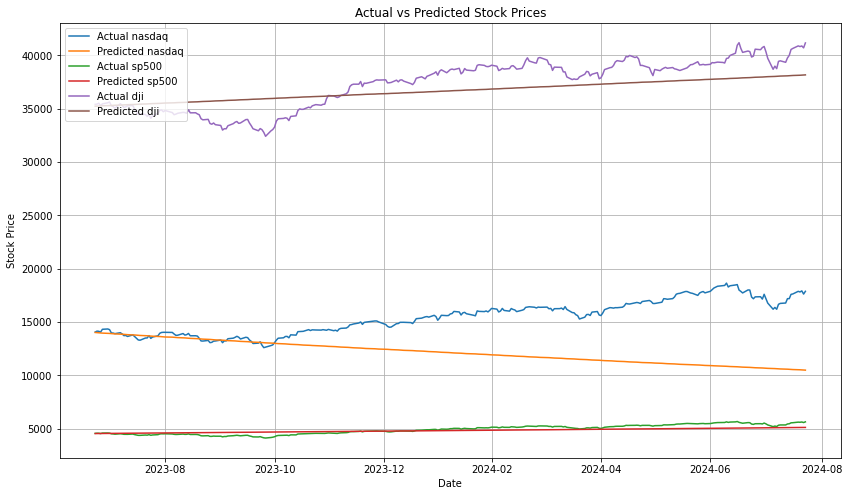

In [23]:
plt.figure(figsize=(14, 8))

for stock in stock_name:
    plt.plot(df_test_close.index, df_test_close[stock], label=f'Actual {stock}')
    plt.plot(df_test_close.index, forecasted_close[stock], label=f'Predicted {stock}')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#### ARIMA - Single-step Prediction - Error Metrics

In [24]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

In [26]:
for stock in stock_name:
    print(f"\nError Metrics for {stock}:")
    y_test = df_test_close[stock].values  # Replace with the actual test data
    y_pred = forecasted_close[stock]  # Replace with the predicted data
    calculate_error_metrics(y_test, y_pred)


Error Metrics for nasdaq:
Mean Squared Error (MSE): 17008379.005671486
Mean Absolute Error (MAE): 3295.013732221944
R-squared (R²): -6.013754175993088

Error Metrics for sp500:
Mean Squared Error (MSE): 82601.36766375983
Mean Absolute Error (MAE): 244.55790723679814
R-squared (R²): 0.5433454502388341

Error Metrics for dji:
Mean Squared Error (MSE): 2900945.6233426197
Mean Absolute Error (MAE): 1519.7088009767433
R-squared (R²): 0.4494813424273648
